## CS310 Natural Language Processing
## Assignment 2. Word2vec Implementation 

**Total points**: 50

Train a word2vec model using the **skip-gram** architecture and **negative sampling**.

You should roughtly follow the structure of the notebook. Add additional cells if you feel needed. 

You can (and you should) re-use the code from *Lab 4 (part 2): Data preparation for implementing word2vec*. 

Make sure your code is readable and well-structured.

### 0. Import Necessary Libraries

In [26]:
from typing import List
from utils import CorpusReader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

## 1. Data Processing

The corpus data is in `lunyu_20chapters.txt`. Use the `CorpusReader` class in `utils.py` to help you.

In [27]:
# Read raw data in lunyu_20chapters.txt

### YOUR CODE HERE ###
corpus = CorpusReader(inputFileName="lunyu_20chapters.txt", min_count=1)
### END YOUR CODE ###

Total vocabulary: 1352


In [28]:
# Re-use the code from lab with necessary modifications

def generate_data(words: List[str], window_size: int, k: int, corpus: CorpusReader):
    """ Generate the training data for word2vec skip-gram model
    Args:
        text: the input text
        window_size: the size of the context window
        k: the number of negative samples
        corpus: the corpus object, providing utilities such as word2id, getNegatives, etc.
    """
    ### YOUR CODE HERE ###
    word_ids = []
    for word in words:
        word_ids.append(corpus.word2id[word])

    for i in range(len(word_ids)):
        center_word = word_ids[i]
        context_words = word_ids[max(0, i - window_size):i] + word_ids[i + 1:i + window_size + 1]
        for context_word in context_words:
            yield center_word, context_word, corpus.getNegatives(center_word, k)
    ### END YOUR CODE ###

def batchify(data: List, batch_size: int):
    """ Group a stream into batches and yield them as torch tensors.
    Args:
        data: a list of tuples
        batch_size: the batch size 
    Yields:
        a tuple of three torch tensors: center, outside, negative
    """
    assert batch_size < len(data) # data should be long enough
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        if i > len(data) - batch_size: # if the last batch is smaller than batch_size, pad it with the first few data
            batch = batch + data[:i + batch_size - len(data)]
        
        ### YOUR CODE HERE ###
        centers = []
        outsides = []
        negatives = []
        for center, outside, negative in batch:
            centers.append(center)
            outsides.append(outside)
            negatives.append(negative)
        centers = torch.tensor(centers)
        outsides = torch.tensor(outsides)
        negatives = torch.tensor(negatives)

        yield centers, outsides, negatives
        ### END YOUR CODE ###

## 2. Define the Model

In [29]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.emb_v = nn.Embedding(vocab_size, emb_size, sparse=True)
        self.emb_u = nn.Embedding(vocab_size, emb_size, sparse=True)

        initrange = 1.0 / self.emb_size # some experience passed down from generation to generation
        nn.init.uniform_(self.emb_v.weight.data, -initrange, initrange) # same outcome as self.emb_v.weight.data.uniform_(-initrange, initrange)
        nn.init.constant_(self.emb_u.weight.data, 0) # same outcome as self.emb_u.weight.data.zero_()

    def forward(self, center, outside, negative):
        """
        Args:
            center: the center word indices (B, )
            outside: the outside word indices (B, )
            negative: the negative word indices (B, k)
        """
        v_c = self.emb_v(center)
        u_o = self.emb_u(outside)
        u_n = self.emb_u(negative)
        
        ### YOUR CODE HERE ###
        loss = None
        pos_score = torch.sum(v_c * u_o, dim=1)
        pos_score_clamped = torch.clamp(pos_score, min=-100, max=100)
        pos_loss = -F.logsigmoid(pos_score_clamped)
        
        neg_score = torch.sum(v_c.unsqueeze(1) * u_n, dim=2)
        neg_score_clamped = torch.clamp(neg_score, min=-100, max=100)
        neg_loss = -F.logsigmoid(-neg_score_clamped)
        neg_loss = torch.sum(neg_loss, dim=1)
        
        loss = pos_loss + neg_loss
        # Hint: torch.clamp the input to F.logsigmoid to avoid numerical underflow/overflow
        ### END YOUR CODE ###
        

        return loss
    
    def save_embedding(self, id2word, file_name):
        embedding = self.emb_v.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

In [30]:
# corpus = CorpusReader('lunyu_20chapters.txt', 1)
vocab_size = corpus.vocab_size

## 3. Train and Evaluate

In [31]:
def train(model, dataloader, optimizer, scheduler, epochs):
    # Write your own code for this train function
    # You don't need exactly the same arguments

    ### YOUR CODE HERE ###
    # 设置模型为训练模式
    
    model.train()
    device = "cpu" if not torch.cuda.is_available() else "cuda"
    epoch_loss = np.zeros(epochs)
    total_steps = 0
    for epoch in tqdm(range(epochs)):
        epoch_loss[epoch] = 0
        epoch_loss_temp = []
        for i, (center_word, context_word, negative_words) in enumerate(dataloader):
            # 将数据移至对应设备
            center_word = center_word.to(device)
            context_word = context_word.to(device)
            negative_words = negative_words.to(device)
            
            # 计算损失
            loss = model(center_word, context_word, negative_words).mean()
            # print(f"loss ,{loss}")
            epoch_loss_temp.append(loss.item())
            # 梯度清零
            optimizer.zero_grad()
            # 反向传播
            loss.backward()
            # 参数更新
            optimizer.step()
            # 学习率调整
            scheduler.step()
            total_steps += 1
            
            # # 每5步打印一次训练信息
            # if (i+1) % 5 == 0:
            #     print(f"Epoch {epoch+1}, Step {i+1}, Loss: {loss.item():.4f}")
        epoch_loss[epoch] = np.mean(epoch_loss_temp)
        if (epoch+1) % 10 == 0:
            print(f"[Epoch {epoch+1}, Loss: {epoch_loss[epoch]:.4f}]")
    return epoch_loss

    ### END YOUR CODE ###

In [32]:

from torch.utils.data import DataLoader
# Suggested hyperparameters
initial_lr = 0.025
batch_size = 16
emb_size = 50
window_size = 5
k = 10 # the number of negative samples, change with your own choice for better embedding performance
min_count = 1 # because our data is small. If min_count > 1, you should filter out those unknown words from the data in train() function
# optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr) # or torch.optim.SparseAdam()
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR() # or torch.optim.lr_scheduler.StepLR()


# text = corpus.words()
with open("lunyu_20chapters.txt", "r", encoding="utf-8") as f:
    text = f.read()
text=text.replace("\n", "")
text=text.replace(" ", "")
words = list(text)
### Hints: ###
# - If you have cuda-supported GPUs, you can run the training faster by
#   `device = torch.device("cuda" if self.use_cuda else "cpu")`
#   `model.cuda()`
#   You also need to move all tensor data to the same device
# - If you find Inf or NaN in the loss, you can try to clip the gradient usning `torch.nn.utils.clip_grad_norm_`
# - Remember to save the embeddings when training is done

In [33]:
model1 = SkipGram(vocab_size, emb_size=50)
data= list(generate_data(words, window_size=1, k=2, corpus=corpus))
train_data = list(batchify(data, batch_size=batch_size))
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SparseAdam(model1.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# Train the model
print(f"Start training with embedding size: {50}")
loss_emb50_k2_win1= train(model1, train_data, optimizer,scheduler,epochs=20)

Start training with embedding size: 50


 50%|█████     | 10/20 [00:35<00:35,  3.58s/it]

[Epoch 10, Loss: 0.9552]


100%|██████████| 20/20 [01:09<00:00,  3.46s/it]

[Epoch 20, Loss: 0.9283]


In [34]:
model2 = SkipGram(vocab_size, emb_size=50)
data= list(generate_data(words, window_size=1, k=5, corpus=corpus))
train_data = list(batchify(data, batch_size=batch_size))
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SparseAdam(model2.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# Train the model
loss_emb50_k5_win_1= train(model2, train_data, optimizer,scheduler,epochs=20)

 50%|█████     | 10/20 [00:43<00:43,  4.39s/it]

[Epoch 10, Loss: 1.5528]


100%|██████████| 20/20 [01:35<00:00,  4.76s/it]

[Epoch 20, Loss: 1.5012]


In [35]:
model3 = SkipGram(vocab_size, emb_size=50)
data= list(generate_data(words, window_size=3, k=2, corpus=corpus))
train_data = list(batchify(data, batch_size=batch_size))
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SparseAdam(model3.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# Train the model
loss_emb50_k2_win_3= train(model2, train_data, optimizer,scheduler,epochs=20)

  5%|▌         | 1/20 [05:39<1:47:38, 339.91s/it]


KeyboardInterrupt: 

In [ ]:
model4 = SkipGram(vocab_size, emb_size=50)
data= list(generate_data(words, window_size=3, k=5, corpus=corpus))
train_data = list(batchify(data, batch_size=batch_size))
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SparseAdam(model4.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# Train the model
loss_emb50_k5_win_3= train(model2, train_data, optimizer,scheduler,epochs=20)

In [ ]:
model5 = SkipGram(vocab_size, emb_size=100)
data= list(generate_data(words, window_size=1, k=2, corpus=corpus))
train_data = list(batchify(data, batch_size=batch_size))
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SparseAdam(model5.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# Train the model
loss_emb100_k2_win_1= train(model2, train_data, optimizer,scheduler,epochs=20)

In [ ]:
model6 = SkipGram(vocab_size, emb_size=100)
data= list(generate_data(words, window_size=1, k=5, corpus=corpus))
train_data = list(batchify(data, batch_size=batch_size))
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SparseAdam(model6.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# Train the model
loss_emb100_k5_win_1= train(model2, train_data, optimizer,scheduler,epochs=20)

In [ ]:
model7 = SkipGram(vocab_size, emb_size=100)
data= list(generate_data(words, window_size=3, k=2, corpus=corpus))
train_data = list(batchify(data, batch_size=batch_size))
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SparseAdam(model7.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# Train the model
loss_emb50_k2_win_3= train(model2, train_data, optimizer,scheduler,epochs=20)

In [ ]:
model8 = SkipGram(vocab_size, emb_size=100)
data= list(generate_data(words, window_size=3, k=5, corpus=corpus))
train_data = list(batchify(data, batch_size=batch_size))
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SparseAdam(model8.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# Train the model
loss_emb100_k5_win_3= train(model2, train_data, optimizer,scheduler,epochs=20)

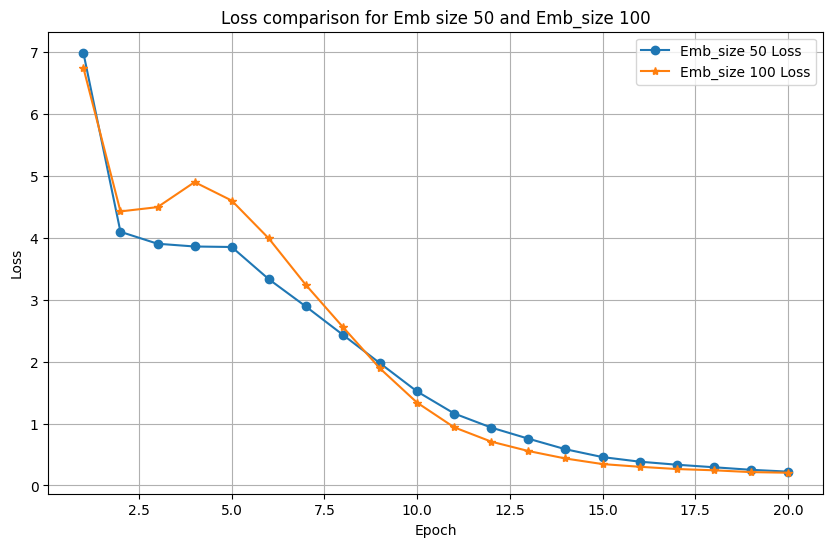

In [ ]:
import matplotlib.pyplot as plt

# 创建两个列表用于存储x和y轴数据
epochs = list(range(1, 21))  # 1到20的epoch数


# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_emb50_k2_win1, marker='o', label='Emb_size 50, k=2, win_size=1')
plt.plot(epochs, loss_emb50_k2_win3, marker='o', label='Emb_size 50, k=2, win_size=3')
plt.plot(epochs, loss_emb50_k5_win1, marker='o', label='Emb_size 50, k=5, win_size=1')
plt.plot(epochs, loss_emb50_k5_win3, marker='o', label='Emb_size 50, k=5, win_size=3')

plt.plot(epochs, loss_emb100_k2_win1, marker='*', label='Emb_size 100, k=2, win_size=1')
plt.plot(epochs, loss_emb100_k2_win3, marker='*', label='Emb_size 100, k=2, win_size=3')
plt.plot(epochs, loss_emb100_k5_win1, marker='*', label='Emb_size 100, k=5, win_size=1')
plt.plot(epochs, loss_emb100_k5_win3, marker='*', label='Emb_size 100, k=5, win_size=3') 

# 设置图表标题和轴标签
plt.title('Loss comparison for Emb size 50 and Emb_size 100')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## 4. Save the Embeddings


Save the embeddings into a `gensim` compatible format.

In [20]:
output_file = 'embeddings.txt'
weights = model1.emb_v.weight.cpu().data.numpy()
with open(output_file, "w") as f:
    f.write(f"{vocab_size} {emb_size}\n")  # First line: vocab size and vector dimension
    for idx, vector in enumerate(weights):
        vector_str = " ".join(map(str, vector))
        f.write(f"{corpus.id2word[idx]} {vector_str}\n") 

## 5. Plot and Compare Embeddings

Use `sklearn.decomposition.TruncatedSVD` to reduce the dimensionality of the obtained embeddings to 2 and plot the selected words in 2D space.

*Hint*:
- Obtain the embeddings into a numpy array by `model.emb_v.cpu().data.numpy()`
- The word2id dictionary is in `model.word2id`
- If you are trying to load from a saved embedding file, you can use the APIs from `gensim`.
  - For exmaple, `model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')`
  - Check out the documentation for more details: https://radimrehurek.com/gensim/models/keyedvectors.html

{'，': 0, '子': 1, '。': 2, '：': 3, '曰': 4, '之': 5, '不': 6, '也': 7, '而': 8, '？': 9, '其': 10, '人': 11, '者': 12, '以': 13, '有': 14, '于': 15, '矣': 16, '为': 17, '君': 18, '乎': 19, '可': 20, '如': 21, '与': 22, '；': 23, '言': 24, '无': 25, '则': 26, '！': 27, '问': 28, '知': 29, '何': 30, '吾': 31, '仁': 32, '夫': 33, '、': 34, '道': 35, '焉': 36, '行': 37, '谓': 38, '必': 39, '礼': 40, '孔': 41, '斯': 42, '三': 43, '能': 44, '见': 45, '学': 46, '事': 47, '是': 48, '哉': 49, '闻': 50, '未': 51, '公': 52, '好': 53, '我': 54, '路': 55, '在': 56, '已': 57, '得': 58, '所': 59, '民': 60, '小': 61, '天': 62, '乐': 63, '邦': 64, '亦': 65, '使': 66, '大': 67, '下': 68, '贡': 69, '欲': 70, '诸': 71, '从': 72, '文': 73, '政': 74, '食': 75, '善': 76, '后': 77, '德': 78, '求': 79, '对': 80, '恶': 81, '信': 82, '死': 83, '然': 84, '《': 85, '》': 86, '由': 87, '仲': 88, '非': 89, '出': 90, '过': 91, '一': 92, '虽': 93, '足': 94, '居': 95, '尔': 96, '夏': 97, '父': 98, '及': 99, '己': 100, '予': 101, '色': 102, '友': 103, '成': 104, '远': 105, '上': 106, '立': 107, '今': 108, '张': 109, '中': 110,

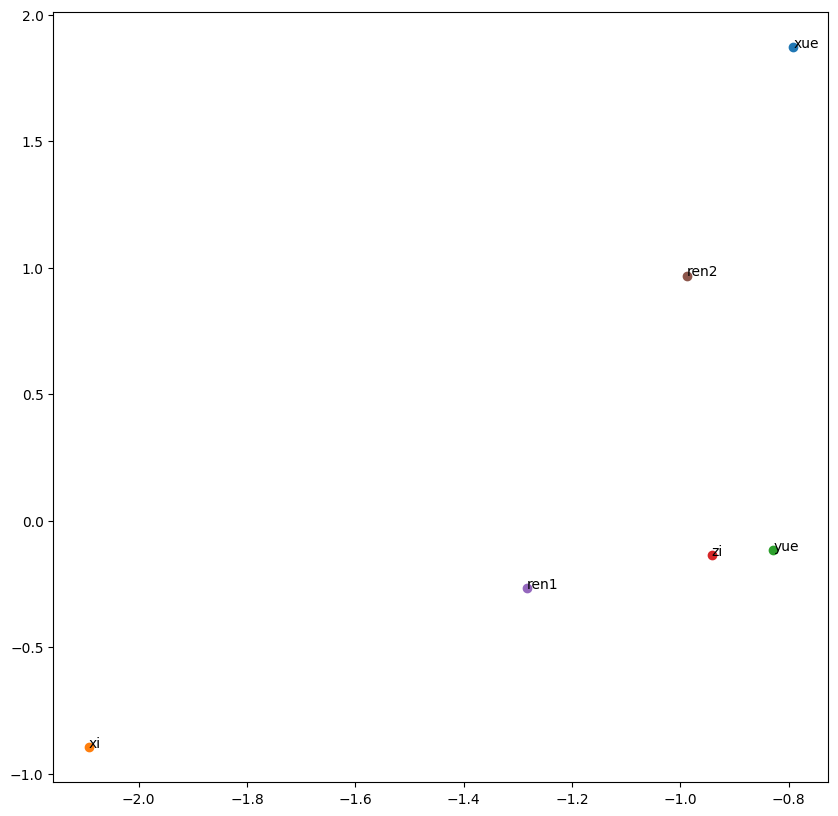

In [21]:
import gensim
# Plot the following words or other words you are interested in
# You better pick those words that look different in the 2D space compared with the LSA vectors
words = ['学', '习', '曰', '子', '人', '仁']
words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']

### YOUR CODE HERE ###
embedding_file = "embeddings.txt"
model = gensim.models.KeyedVectors.load_word2vec_format(embedding_file, binary=False)
print(model.key_to_index)
selected_embeddings = np.array([model[word] for word in words])
# print(selected_embeddings)
svd1 = TruncatedSVD(n_components=2, random_state=42)
M1 = svd1.fit_transform(selected_embeddings)
print(M1)
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(M1[i, 0], M1[i, 1])
    plt.annotate(words_pinyin[i], (M1[i, 0], M1[i, 1]))
plt.show()
### END YOUR CODE ###